# Préambule
___

In [1]:
import pandas as pd

import data_preambule
import strategies
from utils.tool_kit import*

import sys
from joblib import load, Parallel, delayed
from tqdm import tqdm

In [2]:
# parameters
DATA_PATH = '../../data/high_10m.parquet'
NUM_LAGS = 10
NUM_STOCKS = 1000
TRAIN_WINDOW = 50
OUTPUT_PATH = '../../data/processed_high_10m_subset.parquet'
SEED = 42
SHRINKAGE_LIST = [0.0001, 0.001, 0.01, 0.1, 0, 1, 10, 100] # If 0 it is an OLS


In [3]:
sys.argv = [
    'data_preambule.py',
    '--data_path', DATA_PATH,
    '--num_lags', str(NUM_LAGS),
    '--num_random_stocks', str(NUM_STOCKS),
    '--output_path', OUTPUT_PATH,
    '--seed', str(SEED)
]

In [4]:
data_preambule.main()

Loading data...
Creating lag features...
Sampling 1000 random stocks...
Data ready for modeling.
                                  all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                          
PIPR   2021-12-01 11:10:00       DTPNUKZ   170.715  -0.072800  0.001378   
       2021-12-01 11:20:00         DPNTU   170.920   0.142426  0.001201   
       2021-12-01 11:30:00  ZVUKDPNTAYBJ   171.040  -0.217538  0.000702   
       2021-12-01 11:40:00   YPNTUZDKBVH   170.865   1.872702 -0.001023   
       2021-12-01 11:50:00   VPDNKTYHUBZ   169.660   1.482134 -0.007052   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
PIPR   2021-12-01 11:10:00     -0.000147      0.006048     -0.011231   
       2021-12-01 11:20:00      0.001378     -0.000147      0.006048   
       2021-12-01 11:30:00      0.001201      0.001378     -0.000147   
       2021-12-01

In [3]:
# Define the vector of features
features = [f"return_lag_{i}" for i in range(1, 11)]

# OLS Regression
___

In [4]:
# Load dataset
table2 = pd.read_parquet(OUTPUT_PATH)
table2.head(2)

all_ex  mid_open  sum_delta    return  \
symbol timestamp                                                     
PIPR   2021-12-01 11:10:00  DTPNUKZ   170.715  -0.072800  0.001378   
       2021-12-01 11:20:00    DPNTU   170.920   0.142426  0.001201   

                            return_lag_1  return_lag_2  return_lag_3  \
symbol timestamp                                                       
PIPR   2021-12-01 11:10:00     -0.000147      0.006048     -0.011231   
       2021-12-01 11:20:00      0.001378     -0.000147      0.006048   

                            return_lag_4  return_lag_5  return_lag_6  \
symbol timestamp                                                       
PIPR   2021-12-01 11:10:00      0.000584     -0.004677     -0.007983   
       2021-12-01 11:20:00     -0.011231      0.000584     -0.004677   

                            return_lag_7  return_lag_8  return_lag_9  \
symbol timestamp                                                       
PIPR   2021-12-01 11:10:00      0.013524      0.000643      0.007628   
       2021-12-01 11:20:00     -0.007983      0.013524      0.000643   

                            return_lag_10  
symbol timestamp                           
PIPR   2021-12-01 11:10:00       0.000000  
       2021-12-01 11:20:00       0.007628

In [6]:
# Run in parallel
results_nested = Parallel(n_jobs=-1)(
    delayed(run_regression_for_symbol)(
        symbol, group, features=features, train_window=TRAIN_WINDOW
    )
    for symbol, group in tqdm(table2.groupby("symbol"))
)

# Flatten the list of lists
OLS_regression_results = [item for sublist in results_nested for item in sublist]

# Store the results
pd.DataFrame(OLS_regression_results).to_parquet('../../data/OLS_regression_results.parquet', index=False)

100%|██████████| 1000/1000 [02:02<00:00,  8.19it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0449
Market timing returns - SR: 0.0328
Long short returns - SR: 0.0501
R2 score: -0.8379


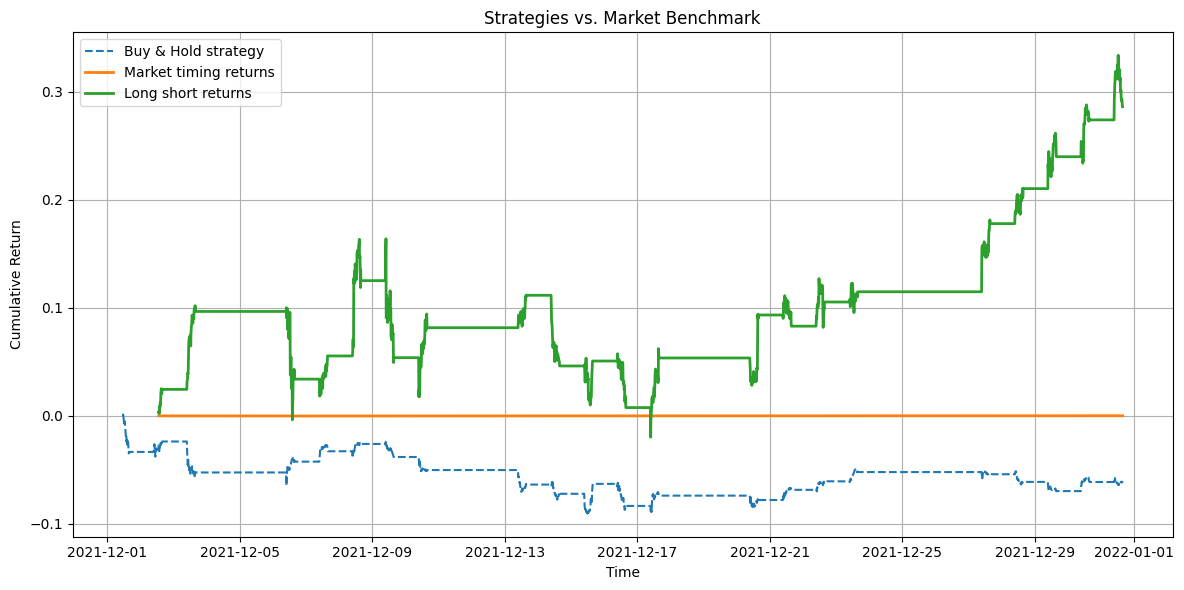

In [7]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ols',
    '--plot', str(False)
]

strategies.main()

# Ridge regression (non-random)
___

In [7]:
# Run in parallel over all symbols
results = Parallel(n_jobs=-1)(
    delayed(run_ridge_for_symbol)(symbol, group, features=features, train_window= TRAIN_WINDOW, shrinkage_list=SHRINKAGE_LIST)
    for symbol, group in tqdm(table2.groupby("symbol"))
)
# Flatten the nested list of predictions
ridge_regression_results = [item for sublist in results for item in sublist]

# Store the results
pd.DataFrame(ridge_regression_results).to_parquet('../../data/ridge_regression_results.parquet', index=False)

100%|██████████| 1000/1000 [09:22<00:00,  1.78it/s]


Loading data...
Running Buy & Hold model...
Buy & Hold - SR: -0.0449
[α=0.0001] Market Timing Sharpe: 0.0298, Long-Short Sharpe: 0.0546, R²: -0.5120
[α=0.001] Market Timing Sharpe: 0.0195, Long-Short Sharpe: 0.0722, R²: -0.2712
[α=0.01] Market Timing Sharpe: 0.0021, Long-Short Sharpe: 0.0491, R²: -0.0908
[α=0.1] Market Timing Sharpe: 0.0209, Long-Short Sharpe: 0.0506, R²: -0.0288
OLS - Market Timing Sharpe: 0.0328, Long-Short Sharpe: 0.0501, R²: -0.8379
[α=1.0] Market Timing Sharpe: 0.0733, Long-Short Sharpe: 0.0849, R²: -0.0178
[α=10.0] Market Timing Sharpe: 0.0811, Long-Short Sharpe: 0.0975, R²: -0.0170
[α=100.0] Market Timing Sharpe: 0.0818, Long-Short Sharpe: 0.0920, R²: -0.0169


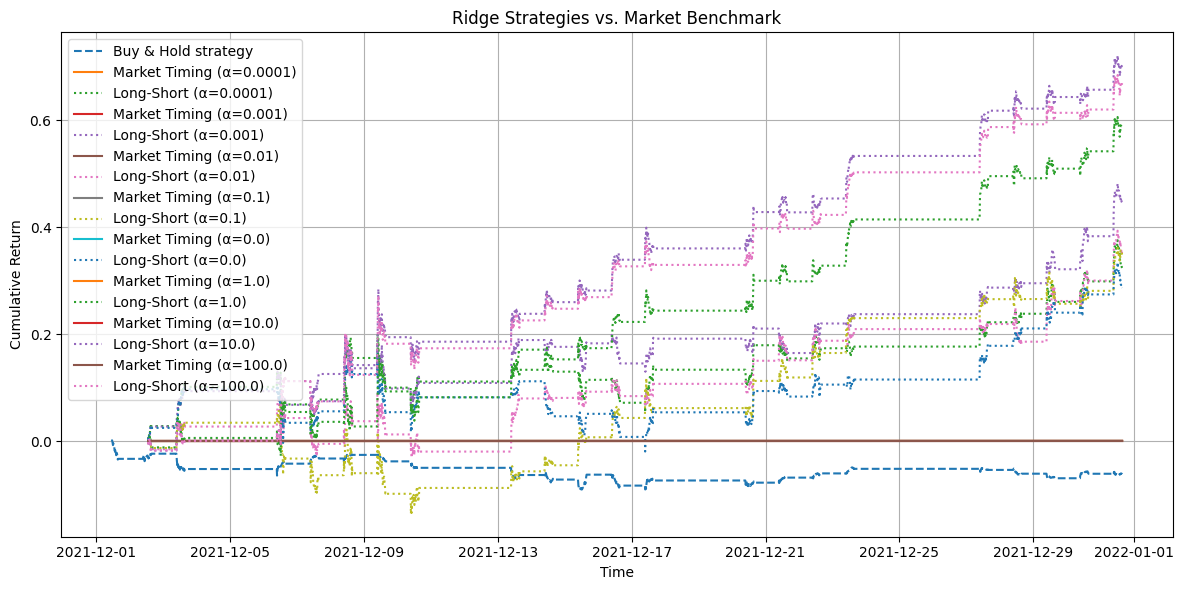

In [5]:
sys.argv = [
    'regressions.py',
    '--data_path', str(OUTPUT_PATH),
    '--model_path', '../../data/',
    '--model', 'ridge',
    '--shrinkage_list', *map(str, SHRINKAGE_LIST),
    '--plot', str(True)
]


strategies.main()